# Default prediction using HMEQ dataset

## About the dataset

**Data Set HMEQ**


The data set HMEQ reports characteristics and delinquency information for 5,960 home equity loans. A home equity loan is a loan where the obligor uses the equity of his or her home as the underlying collateral. The data set has the following characteristics:

    ◾ BAD: 1 = applicant defaulted on loan or seriously delinquent; 0 = applicant paid loan
    ◾ LOAN: Amount of the loan request
    ◾ MORTDUE: Amount due on existing mortgage
    ◾ VALUE: Value of current property
    ◾ REASON: DebtCon = debt consolidation; HomeImp = home improvement
    ◾ JOB: Occupational categories
    ◾ YOJ: Years at present job
    ◾ DEROG: Number of major derogatory reports
    ◾ DELINQ: Number of delinquent credit lines
    ◾ CLAGE: Age of oldest credit line in months
    ◾ NINQ: Number of recent credit inquiries
    ◾ CLNO: Number of credit lines
    ◾ DEBTINC: Debt-to-income ratio

From this dataset, we will try to predict which customer is likely to default, and the probability of default, also the most important features which are used to give prediction

## Analysis

### Import liabraries

In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.compose import make_column_transformer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier


In [2]:
# Load the data

data = pd.read_csv('Downloads/hmeq.csv')
data

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


In [3]:
data.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [5]:
# Find the numerical data

numerical_data = data.select_dtypes('number')
numerical_data = numerical_data.drop(['BAD'], axis=1)
numerical_data

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1100,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1300,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1500,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1700,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...
5955,88900,57264.0,90185.0,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,89000,54576.0,92937.0,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,89200,54045.0,92924.0,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,89800,50370.0,91861.0,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


In [6]:
# Find the categorical data

categorical_data = data.select_dtypes('object')
categorical_data

,REASON,JOB
0,HomeImp,Other
1,HomeImp,Other
2,HomeImp,Other
3,NaN,NaN
4,HomeImp,Office
...,...,...
5955,DebtCon,Other
5956,DebtCon,Other
5957,DebtCon,Other
5958,DebtCon,Other


In [7]:
# Find the missing data

data.isnull().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

In [8]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
BAD,BAD,0.000000
LOAN,LOAN,0.000000
MORTDUE,MORTDUE,8.691275
VALUE,VALUE,1.879195
REASON,REASON,4.228188
JOB,JOB,4.681208
YOJ,YOJ,8.640940
DEROG,DEROG,11.879195
DELINQ,DELINQ,9.731544
CLAGE,CLAGE,5.167785


In [9]:
# Find all the values of the categorical data

for cat in categorical_data:
    print(data[cat].value_counts())

DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64
Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64


In [10]:
# Null values in categorical data

categorical_data.isnull().sum()

REASON    252
JOB       279
dtype: int64

### Some Visualisation

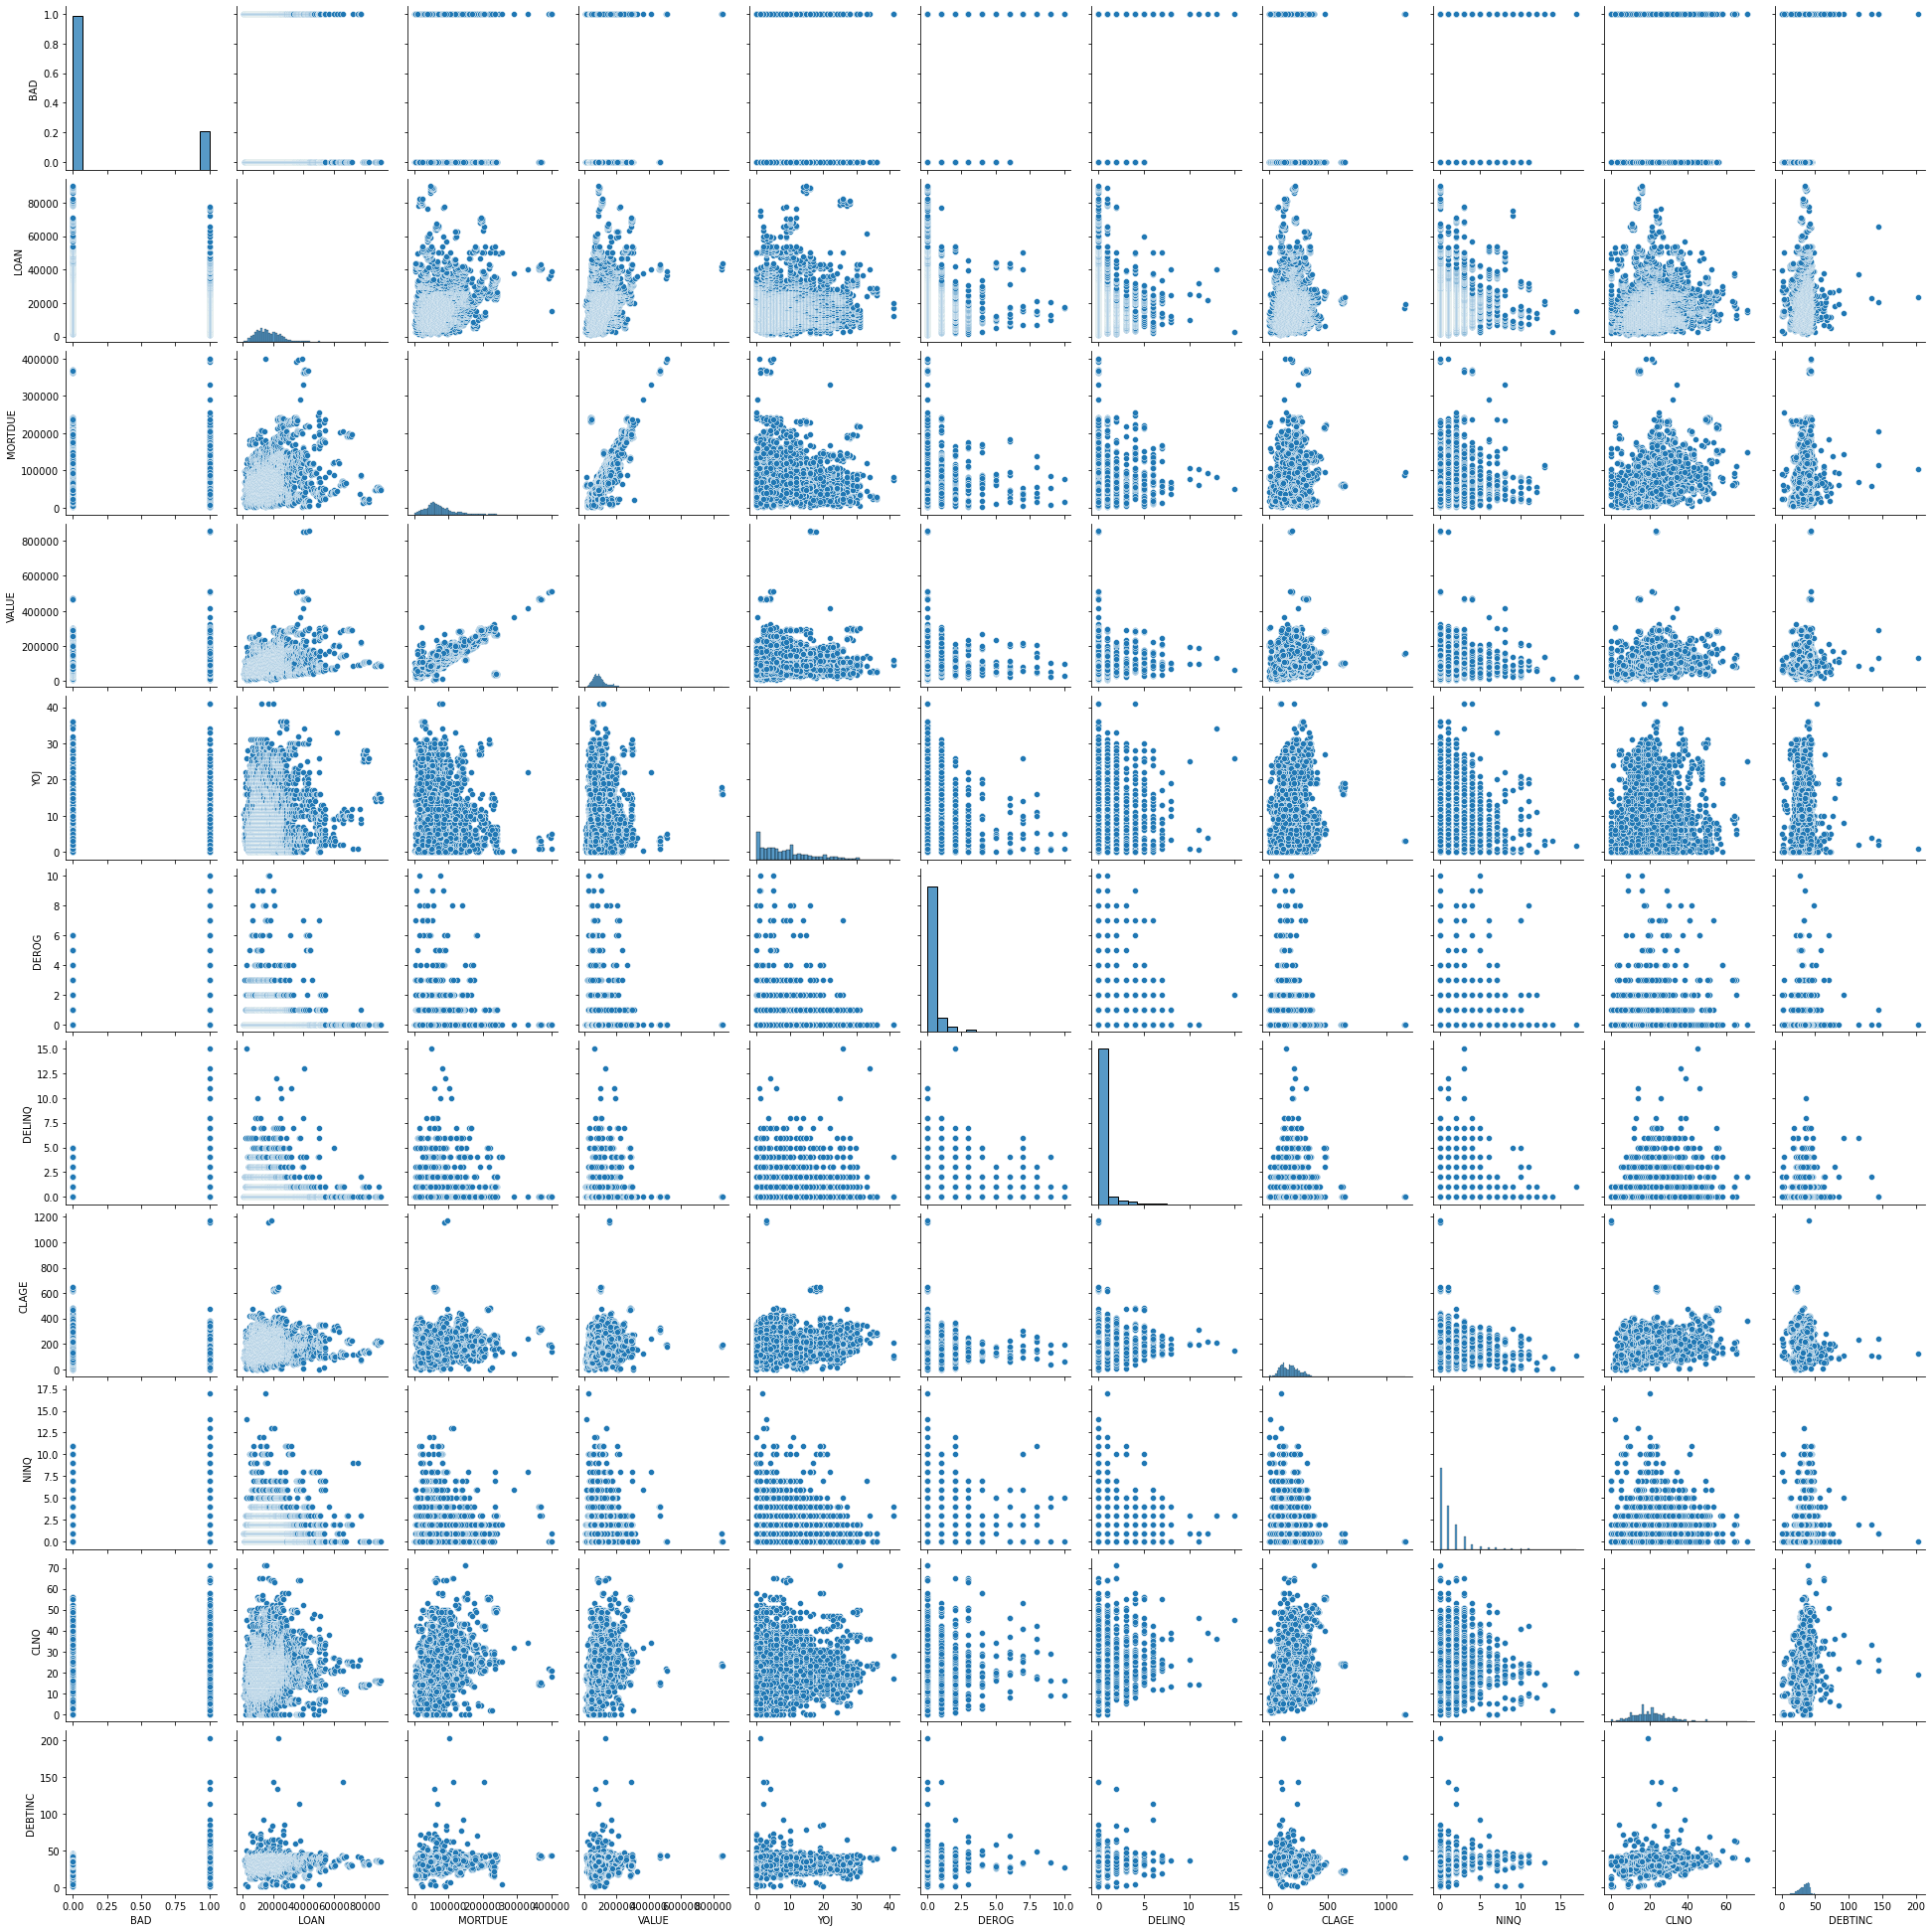

In [11]:
sns.pairplot(data = data)

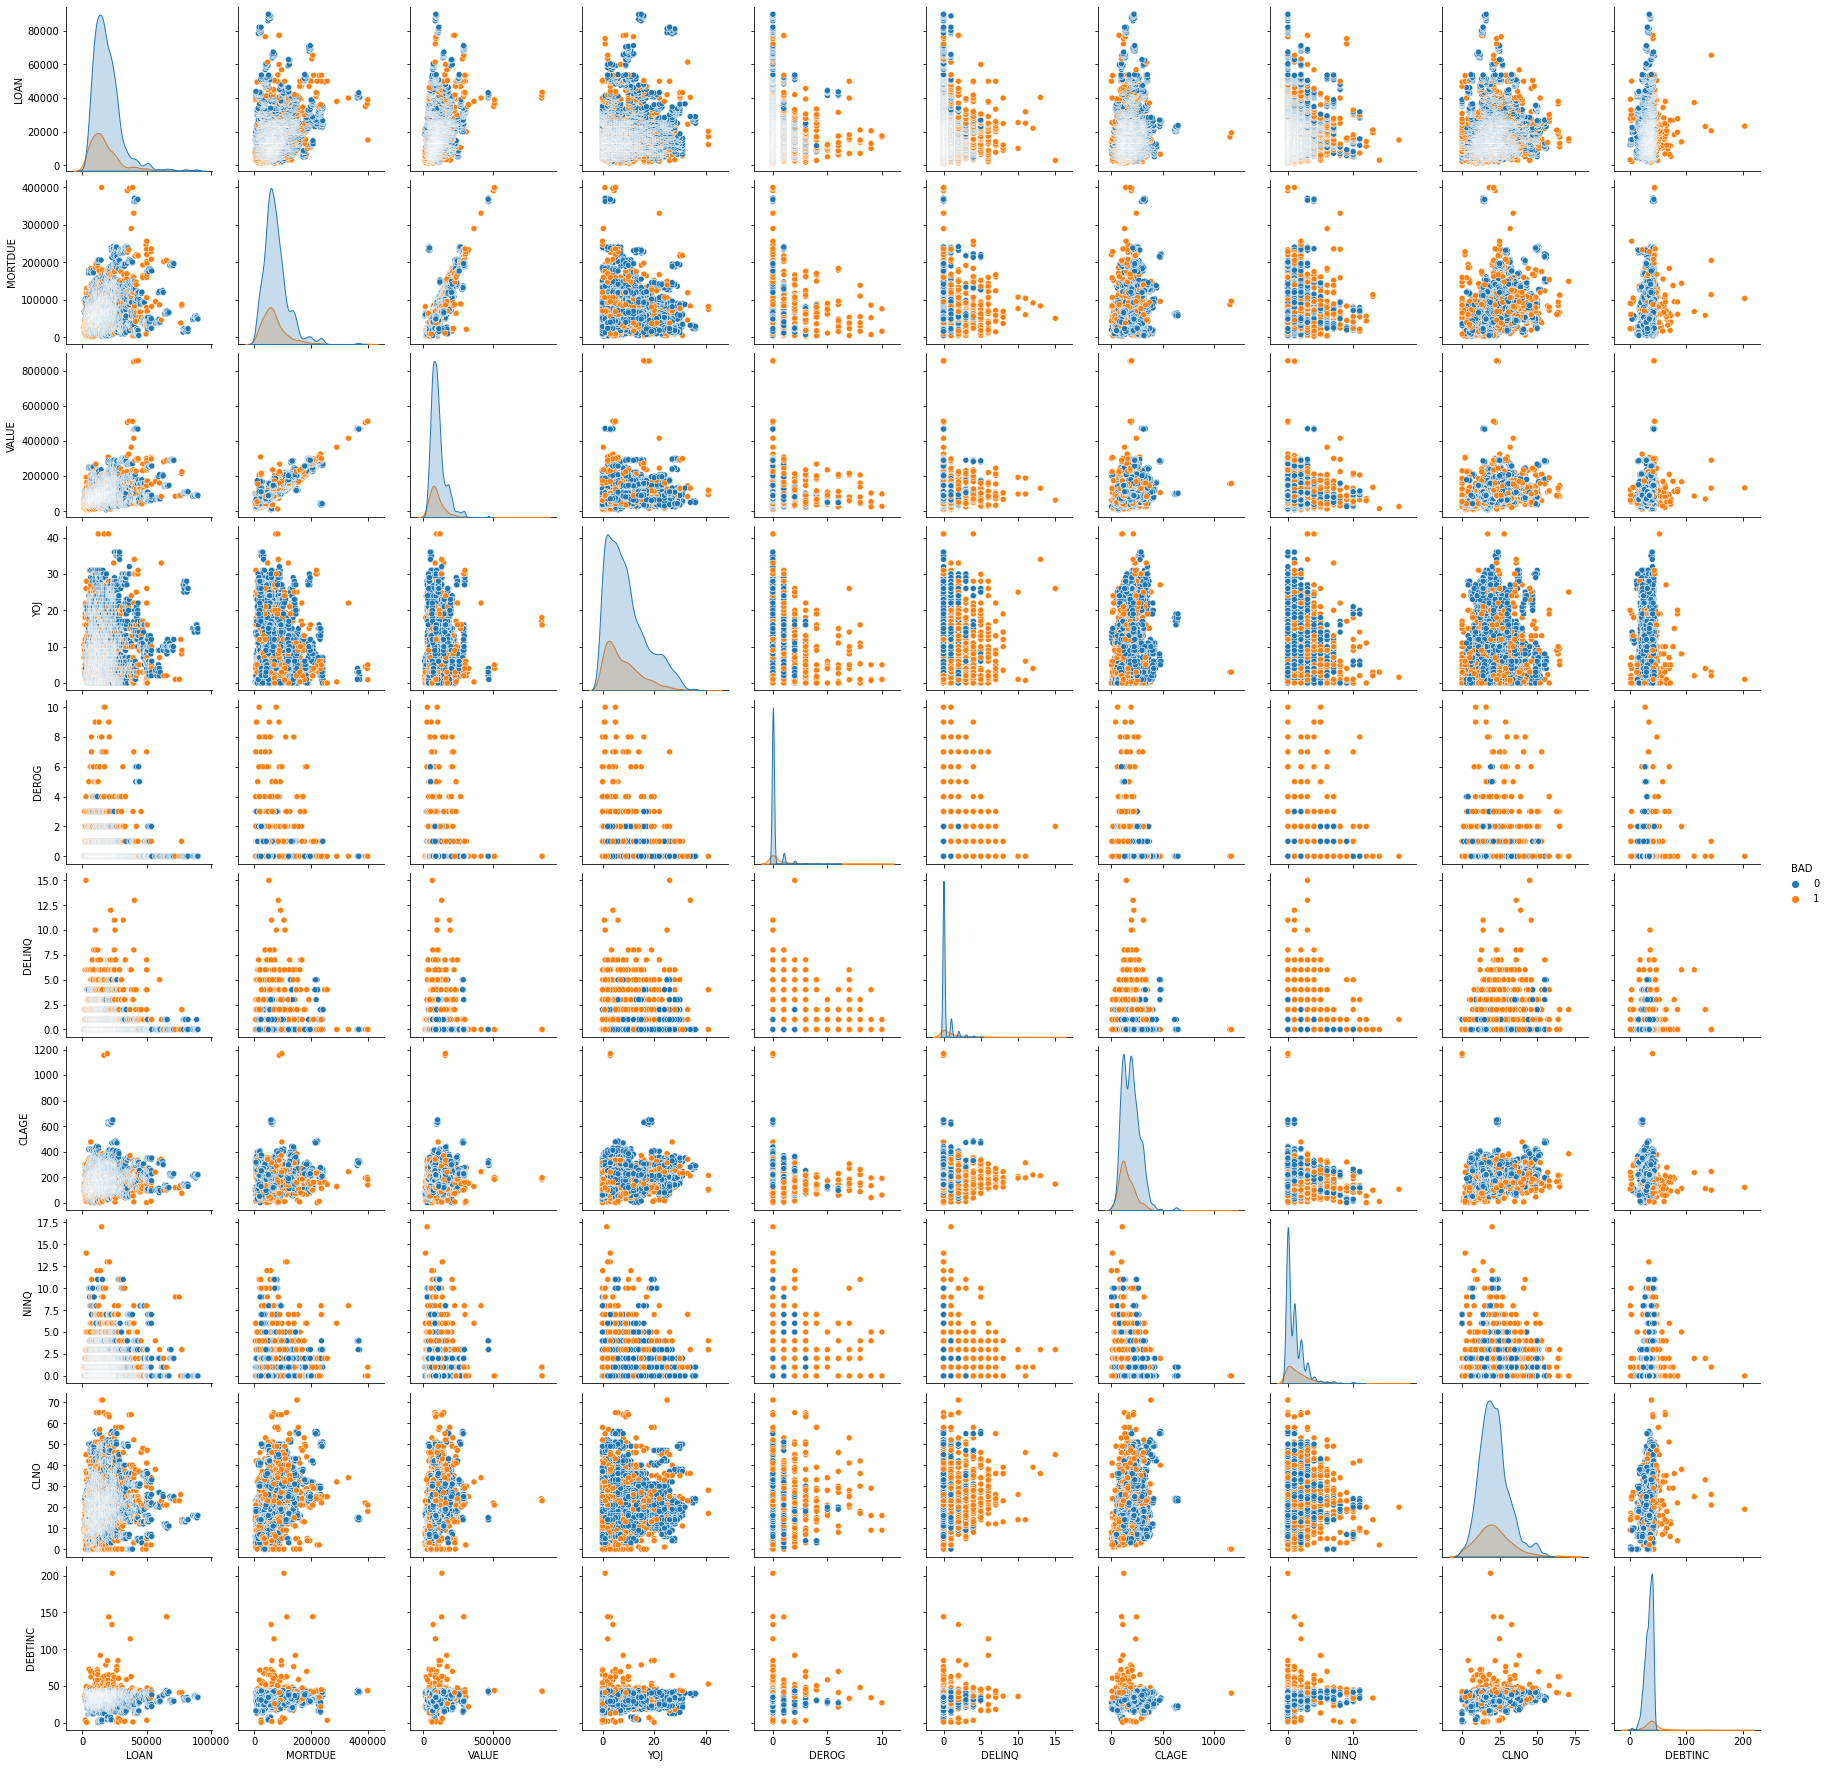

In [12]:
sns.pairplot(data = data, hue = 'BAD')

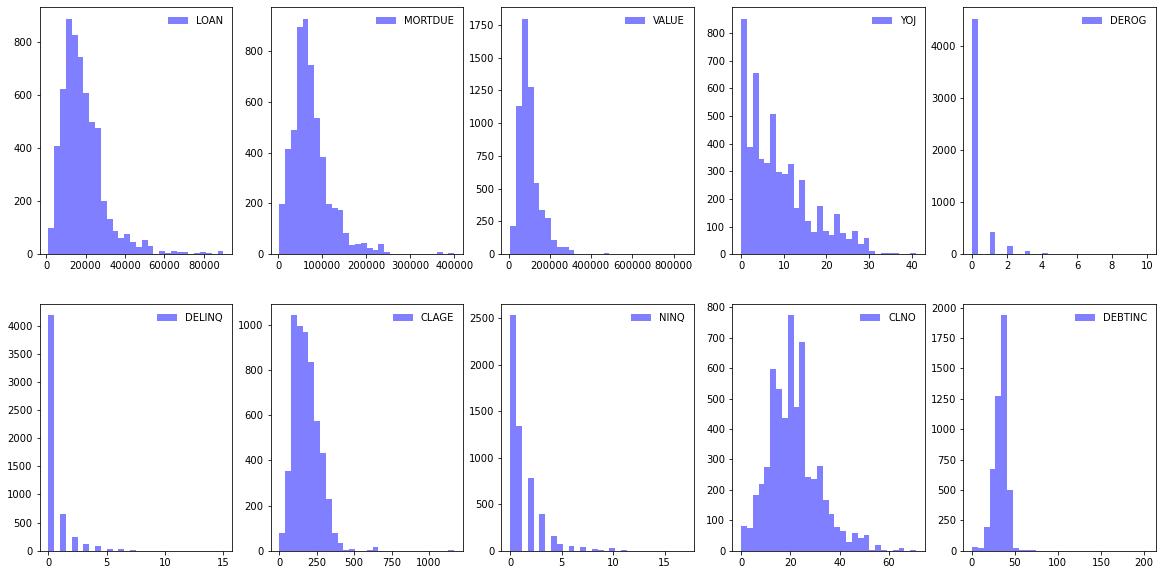

In [13]:
# Plot histogram to show the numerical data's distribution

ncols = 5
nrows = int(np.ceil(len(numerical_data.columns) / (1.0*ncols)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

# Lazy counter so we can remove unwanted axes
counter = 0
for i in range(nrows):
    for j in range(ncols):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len(numerical_data.columns):

            ax.hist(numerical_data[numerical_data.columns[counter]], bins=30, histtype = 'bar', color='blue', alpha=0.5, label='{}'.format(numerical_data.columns[counter]))
            leg = ax.legend(loc='upper right')
            leg.draw_frame(False)

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1

plt.show()

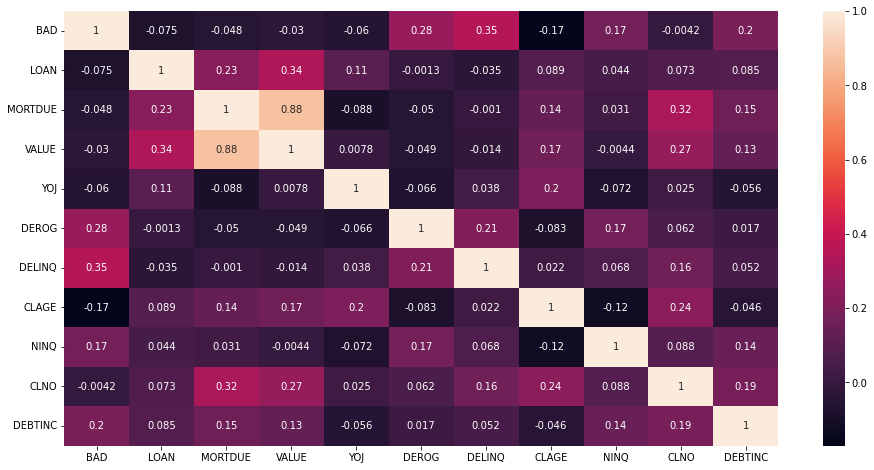

In [14]:
# Correlation between numerical data

cor = data.corr()
f,ax=plt.subplots(1,1,figsize=(16,8))
ax = sns.heatmap(cor, cbar=True, annot=True)

<AxesSubplot:xlabel='BAD', ylabel='count'>

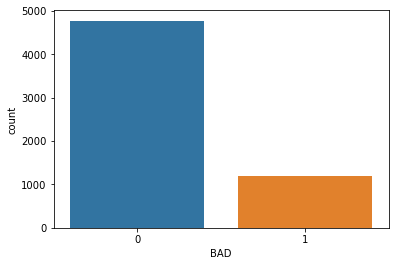

In [15]:
sns.countplot(data = data, x='BAD')

We can see that out data is imbalance, which could cause problems to our prediction. Let’s explain it with an example of disease diagnosis. Let’s assume we are going to predict disease from an existing dataset where for every 100 records only 5 patients are diagnosed with the disease. So, the majority class is 95% with no disease and the minority class is only 5% with the disease. Now, assume our model predicts that all 100 out of 100 patients have no disease.
Sometimes when the records of a certain class are much more than the other class, our classifier may get biased towards the prediction. It means that the model fails to identify the minority class yet the accuracy score of the model will be 95%.

In our cases, the model may not "catch" the one who most likely to default. To solve this type of problem, we need to do the resampling techniques.

### Feature engineering

In [16]:
df = data.copy()

# Dummy encoding our categorical data
df=pd.get_dummies(df, columns=['REASON','JOB'])


Imputing missing values with statistical averages is probably the most common technique. You can impute missing values with the mean if the variable is normally distributed, and the median if the distribution is skewed. It is easy to implement and understand, and is fast on datasets of any size. Howerver, it can slightly or drastically change the original distribution, depending on how many values are missing.


MissForest is a machine learning-based imputation technique. It uses a Random Forest algorithm to do the task. It is based on an iterative approach, and at each iteration the generated imputations are better. There are several advantages to using Missing Forest for imputation:

    It can work with mixed data, both numerical and categorical
    Miss Forest can handle outliers, so there is no need for feature scaling.
    Random Forests have inherent feature selection, which makes them robust to noisy data.
    It can handle non-linearity in data

Disadvantages of Missing Forest:

    Multiple trees need to be constructed for each iteration, and it becomes computationally expensive when the number of predictors and observations increases.
    Also, it’s an algorithm, not a model object, meaning it must be run every time data is imputed, which could be problematic in some production environments.



In [17]:
# Missing forest imputation

imputer = MissForest()

df_impute = imputer.fit_transform(df)



/Users/namlenguyen/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/namlenguyen/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/namlenguyen/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/namlenguyen/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416

Iteration: 0


/Users/namlenguyen/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/namlenguyen/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/namlenguyen/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/namlenguyen/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416

Iteration: 1


/Users/namlenguyen/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/namlenguyen/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/namlenguyen/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/namlenguyen/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416

Iteration: 2


/Users/namlenguyen/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/namlenguyen/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/namlenguyen/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/namlenguyen/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416

Iteration: 3


In [18]:
df_impute = pd.DataFrame(df_impute, columns=df.columns)

df_impute.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
count,5960.000000,5960.000000,5960.000000,5960.00000,5960.000000,5960.00000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000
mean,0.199497,18607.969799,70826.531832,101750.78536,8.993449,0.27978,0.503483,184.274364,1.226938,21.315680,34.431714,0.659060,0.298658,0.128691,0.159060,0.400671,0.214094,0.018289,0.032383
std,0.399656,11207.480417,44908.720415,57609.73113,7.331752,0.81409,1.108072,100.566505,1.693039,9.987201,8.702616,0.474065,0.457708,0.334886,0.365763,0.490076,0.410227,0.134004,0.177029
min,0.000000,1100.000000,2063.000000,8000.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.524499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,11100.000000,42217.250000,66000.00000,3.000000,0.00000,0.000000,116.852249,0.000000,15.000000,29.807593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,16300.000000,62591.500000,89126.00000,7.813000,0.00000,0.000000,172.032201,1.000000,20.000000,35.232468,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,23300.000000,89000.000000,119824.25000,13.000000,0.00000,0.970000,230.429581,2.000000,26.000000,39.217174,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,89900.000000,399550.000000,855909.00000,41.000000,10.00000,15.000000,1168.233561,17.000000,71.000000,203.312149,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
# Compare to the original data

data.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [20]:
# Check if there is any null value left in our data just to make sure

df_impute.isnull().sum()

BAD               0
LOAN              0
MORTDUE           0
VALUE             0
YOJ               0
DEROG             0
DELINQ            0
CLAGE             0
NINQ              0
CLNO              0
DEBTINC           0
REASON_DebtCon    0
REASON_HomeImp    0
JOB_Mgr           0
JOB_Office        0
JOB_Other         0
JOB_ProfExe       0
JOB_Sales         0
JOB_Self          0
dtype: int64

In [21]:
# Scaling our numerical data

scale = preprocessing.StandardScaler()
num =  ['LOAN', 'MORTDUE', 'VALUE','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC']
preprocess = make_column_transformer((scale, num), remainder='passthrough')





In [22]:
X = df_impute.drop(columns=df_impute.columns[0], axis=1)
X = preprocess.fit_transform(X)
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.562299,-1.001371,-1.088897,0.205500,-0.343701,-0.454416,-0.894087,-0.134053,-1.233250,-0.153529,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.544453,-0.017226,-0.578957,-0.271915,-0.343701,1.350672,-0.620945,-0.724756,-0.732567,-0.022124,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.526606,-1.276619,-1.476451,-0.681129,-0.343701,-0.454416,-0.346145,-0.134053,-1.133113,-0.544453,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.526606,-0.581675,-0.692599,0.536963,1.277877,2.226140,-0.686463,-0.039540,-0.188825,-0.180001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.508759,0.600679,0.177923,-0.817533,-0.343701,-0.454416,-0.904363,-0.724756,-0.732567,-0.372256,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,6.272411,-0.302028,-0.200778,0.955725,-0.343701,-0.454416,0.373260,-0.724756,-0.532294,0.193134,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5956,6.281335,-0.361887,-0.153004,0.955725,-0.343701,-0.454416,0.242822,-0.724756,-0.632430,0.164132,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5957,6.299181,-0.373712,-0.153230,0.819321,-0.343701,-0.454416,0.278499,-0.724756,-0.632430,0.129268,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5958,6.352722,-0.455552,-0.171683,0.682916,-0.343701,-0.454416,0.294540,-0.724756,-0.532294,-0.010438,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [23]:
y = df['BAD']
y

0       1
1       1
2       1
3       1
4       0
       ..
5955    0
5956    0
5957    0
5958    0
5959    0
Name: BAD, Length: 5960, dtype: int64

### Make classification

#### Without resampling

In [24]:
# Split data into train and test

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, stratify=y)


In [25]:
# Logistic regression

log = LogisticRegression()
log.fit(X_train, y_train)
y_pred = log.predict(X_test)
acc = classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1431
           1       0.70      0.32      0.44       357

    accuracy                           0.84      1788
   macro avg       0.77      0.64      0.67      1788
weighted avg       0.82      0.84      0.81      1788



In [26]:
# Random forest classifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1431
           1       0.98      0.70      0.82       357

    accuracy                           0.94      1788
   macro avg       0.95      0.85      0.89      1788
weighted avg       0.94      0.94      0.93      1788



Looking at the classification report, we can see that Random Forest is better in every metric, compare to Logistic Regression. However, as we state above, due to the imbalance problem, we left out a lot of potential default-customer. Looking at the Recall metric, for Logistic Regression, **we can only catch 32% of the default cases, while in Random Forest is 70%**. This is the type 2 error which we want to avoid the most (reject the hypothesis when it is true).

#### With resampling

A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary.

One way to solve this problem is to oversample the examples in the minority class. This can be achieved by simply duplicating examples from the minority class in the training dataset prior to fitting a model. This can balance the class distribution but does not provide any additional information to the model.

An improvement on duplicating examples from the minority class is to synthesize new examples from the minority class. This is a type of data augmentation for tabular data and can be very effective.

Perhaps the most widely used approach to synthesizing new examples is called the Synthetic Minority Oversampling TEchnique, or SMOTE for short. This technique was described by Nitesh Chawla, et al. in their 2002 paper named for the technique titled “SMOTE: Synthetic Minority Over-sampling Technique.”

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

In [27]:
# Synthetic Minority Oversampling Technique

oversample = SMOTE(sampling_strategy='minority')
X_resam, y_resam = oversample.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_resam))



Resampled dataset shape Counter({0: 3340, 1: 3340})


In [28]:
# Logistic regression with resampling

log1 = LogisticRegression()
log1.fit(X_resam, y_resam)
y_pred_resample = log1.predict(X_test)

print(classification_report(y_test, y_pred_resample))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83      1431
           1       0.43      0.71      0.54       357

    accuracy                           0.75      1788
   macro avg       0.67      0.74      0.68      1788
weighted avg       0.82      0.75      0.77      1788



Looking at the classification report of Logistic regression with resampling,  we can see that the resampling technique did improve  the recall of class 1 which we are focusing. But compare to Random Forest without resampling, it is not good. Futhermore, the resampling technique damage other metrics such as precision and accuracy. Now let's move on the Random Forest with resampling.

In [29]:
# Random Forest with resampling

rf1 = RandomForestClassifier()
rf1.fit(X_resam, y_resam)
y_pred_rf_resam = rf1.predict(X_test)
print(classification_report(y_test, y_pred_rf_resam))


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1431
           1       0.93      0.85      0.89       357

    accuracy                           0.96      1788
   macro avg       0.95      0.91      0.93      1788
weighted avg       0.96      0.96      0.96      1788



Here we can see that the resampling technique improved both recall of class 1 by a lot without damaging much to other metrics. It also improved the total accuracy compare to the Random Forest without resampling.

#### Pros and cons of both model

***Logistic Regression***

Pros

    1. Simple to implement
    2. Effective

    3. Feature scaling not needed: Does not require input features to be scaled (can work with scaled features too, but doesn’t require scaling)

    4. Tuning of hyperparameters not needed.

Cons

    1. Poor performance on non-linear data(image data for e.g)
    2. Poor performance with irrelevant and highly correlated features (use Boruta plot for removing similar or correlated features and irrelevant features).

    3. Not very powerful algorithm and can be easily outperformed by other algorithms.

    4. High reliance on proper presentation of data. All the important variables / features should be identified for it to work well.
    
    
    
    
***Random Forest***
Pros:

    1. Random forest can decorrelate trees. It picks the training sample and gives each tree a subset of the features(suppose training data was [1,2,3,4,5,6], so one tree will get subset of training data [1,2,3,2,6,6]. Note that size of training data remains same, both datas have length 6 and that feature ‘2’ and feature ‘6’ are repeated in the randomly sampled training data given to one tree. Each tree predicts according to the features it has. In this case tree 1 only has access to features 1,2,3 and 6 so it can predict based on these features. Some other tree will have access to features 1,4,5 say so it will predict according to those features. If features are highly correlated then that problem can be tackled in random forest.
    
    2. Reduced error: Random forest is an ensemble of decision trees. For predicting the outcome of a particular row, random forest takes inputs from all the trees and then predicts the outcome. This ensures that the individual errors of trees are minimized and overall variance and error is reduced.

    3. Good Performance on Imbalanced datasets : It can also handle errors in imbalanced data (one class is majority and other class is minority)

    4. Handling of huge amount of data: It can handle huge amount of data with higher dimensionality of variables.

    5. Good handling of missing data: It can handle missing data very well. So if there is large amount of missing data in your model, it will give good results.

    6. Little impact of outliers: As the final outcome is taken by consulting many decision trees so certain data points which are outliers will not have a very big impact on Random Forest.

    7. No problem of overfitting: In Random forest considers only a subset of features, and the final outcome depends on all the trees. So there is more generalization and less overfitting.

    8. Useful to extract feature importance (we can use it for feature selection)

Cons:

    1. Features need to have some predictive power else they won’t work.

    2. Predictions of the trees need to be uncorrelated.

    3. Appears as Black Box: It is tough to know what is happening. You can at best try different parameters and random seeds to change the outcomes and performance.

In [30]:
# Feature importance

feature_scores = pd.Series(rf1.feature_importances_, index=df.drop(columns=df_impute.columns[0], axis=1).columns).sort_values(ascending=False)

feature_scores

DEBTINC           0.164889
DELINQ            0.120020
CLAGE             0.107519
LOAN              0.079444
CLNO              0.078459
VALUE             0.073289
YOJ               0.070002
MORTDUE           0.067211
DEROG             0.060403
NINQ              0.056801
JOB_Other         0.037974
JOB_Office        0.019547
REASON_HomeImp    0.015014
JOB_Mgr           0.014937
REASON_DebtCon    0.014003
JOB_ProfExe       0.011468
JOB_Sales         0.006556
JOB_Self          0.002463
dtype: float64

We can see that 'Debt to income Ratio' and ' Number of delinquent credit lines' and ' Age of oldest credit line in months' are the most important 3 features in our random forest model.

In [31]:
# Add the probability of default to our dataframe


data['Probability of default rf'] = rf1.predict_proba(X)[:,1]
data['Probability of default logistic'] = log1.predict_proba(X)[:,1]
data

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,Probability of default rf,Probability of default logistic
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN,1.00,0.551063
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN,0.84,0.838131
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN,0.97,0.436651
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.89,0.881974
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN,0.02,0.231149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347,0.00,0.067354
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971,0.00,0.070528
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,0.00,0.068773
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882,0.01,0.057639


# Conclusion

We have handle many problems of this dataset, including impute the missing data by a Random Forest model, resample our data using SMOTE, comparing the regression based model to the ensembles - tree based model, showing the feature importance and probability of default of each observations. The classification report shows that the ensembles model are much better than the regression model in every metric. Hence our recommendation is to use Random Forest model for this dataset.

We have not try every techniques yet (different imputation method, different data scaling method, different resampling method,...), so it is still possible to improve our model in the future.